In [12]:
from astroquery.gaia import Gaia
import pyvo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
""" get the clean DA wds from Napiwotski+2020
"""
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select da.Name, da.GaiaDR2, da.Teff as SPYTeff, da.logg as SPYlogg, da.Rem, objects.FileName
        from \"J/A+A/638/A131/tablec2\" as da
        join \"J/A+A/638/A131/objects\" as objects
        on da.Name = objects.Name
        where da.Rem = ' '
        """
table = tap_service.search(QUERY).to_table().to_pandas()

In [14]:
""" cross-match against Gaia
"""
QUERY = f"""select dr2.dr2_source_id as GaiaDR2, bj.r_med_geo, gaia.*
        from gaiadr3.gaia_source as gaia
        join gaiadr3.dr2_neighbourhood as dr2
                on gaia.source_id = dr2.dr3_source_id
        join external.gaiaedr3_distance as bj
                on bj.source_id = gaia.source_id
        where dr2.dr2_source_id in {tuple(table.GaiaDR2)}
        and parallax_over_error > 5
        and ruwe < 1.25
        """
gaia_table = Gaia.launch_job_async(QUERY).get_results().to_pandas()
full_table = pd.merge(table, gaia_table, on="GaiaDR2")
full_table['FileName'] = full_table['FileName'].astype(str) + '.gz'

INFO: Query finished. [astroquery.utils.tap.core]


1181

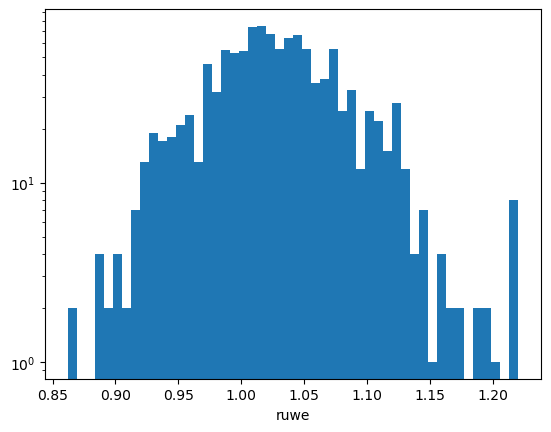

In [15]:
""" check RUWE to mitigate binary contamination
"""
plt.hist(full_table.ruwe, bins = 50)
plt.xlabel('ruwe')
plt.yscale('log')

full_table = full_table.query("ruwe < 1.25")
len(full_table)

In [16]:
def merge_ngf21(source_ids):
    tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
    QUERY = f"""select GaiaEDR3, TeffH, e_TeffH, loggH, e_loggH 
            from \"J/MNRAS/508/3877/maincat\"
            where GaiaEDR3 in {tuple(source_ids)}"""
    return tap_service.search(QUERY).table.to_pandas()

data = pd.merge(full_table, merge_ngf21(full_table.SOURCE_ID), left_on='SOURCE_ID', right_on = 'GaiaEDR3')

In [17]:
data = data.drop(columns=['FileName', 'GaiaEDR3','GaiaDR2'])
data.drop_duplicates(inplace=True,)
data.to_csv('../data/goodcoadds.csv', index=False)

In [18]:
from astropy.io import fits
spec = fits.open('../data/raw/sdss5/wd_fits/spSpec-015004-59191-4402835442.fits')
sdsswavl = 10**spec[1].data['LOGLAM']

In [21]:
from Payne.utils import smoothing
from tqdm import tqdm

for source in tqdm(data.SOURCE_ID):
    spec = pd.read_csv(f'../data/raw/coadd/{source}.csv')
    wavl, flux, ivar = spec.wavl, spec.flux, spec.ivar
    mask = (min(wavl) < sdsswavl) * (sdsswavl < 6564.6+70)
    flux = smoothing.smoothspec(wavl, flux, resolution=1800, smoothtype='R', outwave=sdsswavl[mask])
    ivar = np.interp(sdsswavl[mask], wavl, ivar)
    spec = pd.DataFrame({'wavl' : sdsswavl[mask], 'flux' : flux, 'ivar' : ivar})
    spec.to_csv(f'../data/raw/coadd_smooth/{source}.csv', index=False)


  0%|          | 0/547 [00:00<?, ?it/s]

100%|██████████| 547/547 [02:48<00:00,  3.25it/s]
